# HR Analytics: Job Change of Data Scientists.

# Extracting data directly from Kaggle to Google Drive and Colab

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Configuration environment
import os

os.environ['KAGGLE_USERNAME'] = "priyankadandale" # username from the json file
os.environ['KAGGLE_KEY'] = "1bb2d68a77eeaff50198bd6bb816daef" # key from the json file

In [ ]:
#Download hr-analytics-job-change-of-data-scientists data from Kaggle API
!kaggle datasets download -d arashnic/hr-analytics-job-change-of-data-scientists

hr-analytics-job-change-of-data-scientists.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip -q "/content/hr-analytics-job-change-of-data-scientists.zip"

replace aug_test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace aug_train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


# Data Understanding

In [ ]:
import pandas as pd

df = pd.read_csv("/content/aug_train.csv")
df.shape

(19158, 14)

In [ ]:
df.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df.columns

Index(['enrollee_id', 'city', 'city_development_index', 'gender',
       'relevent_experience', 'enrolled_university', 'education_level',
       'major_discipline', 'experience', 'company_size', 'company_type',
       'last_new_job', 'training_hours', 'target'],
      dtype='object')

# Features Description

* enrollee_id : Unique ID for enrollee

* city : City code

* city_development_index : Developement index of the city (scaled)

* gender : Registered person gender (M/F)

* relevent_experience : Relevent experience

* enrolled_university : Type of university of the enrolee

* education_level : edu level

* major_discipline : edu discipline of enrollee

* experience : Total experience in years

* company_size : No of employees in current employer's company

* company_type : Type of current employer

* last_new_job : Difference in years between previous job and current job

* training_hours : training hours completed

* target : 0 – Not looking for job change, 1 – Looking for a job change

# Data Correction

* In the dataset, there is some Human error in column company size i.e. Oct-49 and in pandas it was printed as 10/49, so we need to convert into np.nan(NaN).

In [ ]:
import numpy as np
df['company_size'] = df['company_size'].replace('10/49', np.nan)
df['company_size'].value_counts()

50-99        3083
100-500      2571
10000+       2019
1000-4999    1328
<10          1308
500-999       877
5000-9999     563
Name: company_size, dtype: int64

# Replacing Target values by string

Not looking for job change    14381
Looking for a job change       4777
Name: target, dtype: int64 



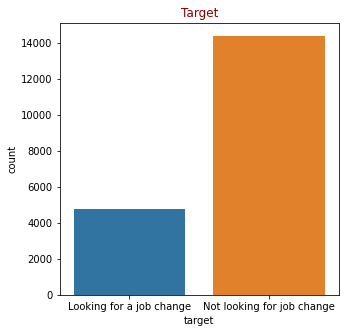

In [ ]:
import seaborn as sns

df["target"].replace({0.0: "Not looking for job change", 1.0: "Looking for a job change"}, inplace=True)
print(df["target"].value_counts(),'\n')

import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
sns.countplot(df["target"],  data = df)
plt.title("Target", color = "darkred")
plt.show()

## How many missing values present? What is the percentage of missing values?


In [ ]:
def count_percent(data):
  df_cols = pd.DataFrame({'Count Missing': data.isnull().sum(),
                        'Percent Missing': data.isnull().sum()*100/data.shape[0]})
  return df_cols

count_percent(df)

,Count Missing,Percent Missing
enrollee_id,0,0.000000
city,0,0.000000
city_development_index,0,0.000000
gender,4508,23.530640
relevent_experience,0,0.000000
enrolled_university,386,2.014824
education_level,460,2.401086
major_discipline,2813,14.683161
experience,65,0.339284
company_size,7409,38.673139


In [ ]:
df_cols= count_percent(df)
df_cols[df_cols['Count Missing']>0].index

Index(['gender', 'enrolled_university', 'education_level', 'major_discipline',
       'experience', 'company_size', 'company_type', 'last_new_job'],
      dtype='object')

* Above 8 features have missing values.

# Remove unnecessary columns

In [ ]:
df.drop(['enrollee_id', 'city'], axis = 1, inplace=True)
df.shape

(19158, 12)

# Missing Value Imputation

* Below 8 features have missing values. Now we will try to fix this issue.

In [ ]:
df_cols = count_percent(df)
print(df_cols[df_cols['Count Missing']>0],'\n')

                     Count Missing  Percent Missing
gender                        4508        23.530640
enrolled_university            386         2.014824
education_level                460         2.401086
major_discipline              2813        14.683161
experience                      65         0.339284
company_size                  7409        38.673139
company_type                  6140        32.049274
last_new_job                   423         2.207955 



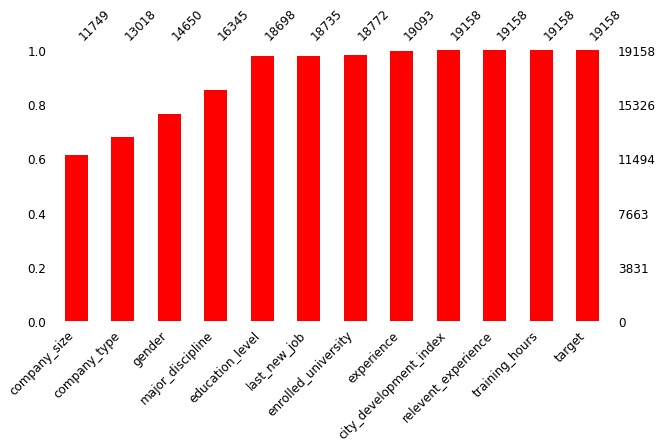

In [ ]:
import missingno as msno
msno.bar(df,figsize=(10,5),color='red',fontsize=12,sort="ascending",log=False);

# Missing Value Imputation - MICE

* MICE (Multiple Imputation by Chained Equations) Imputation. Its a multiple imputation method, it is generally better than single imputation method like mean imputation.

In [ ]:
df["target"].replace({"Not looking for job change":0.0,  "Looking for a job change":1.0}, inplace=True)
df["target"].value_counts()

0.0    14381
1.0     4777
Name: target, dtype: int64

In [ ]:
from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder
to_LabelEncode = df[['gender', 'relevent_experience',
       'enrolled_university', 'education_level', 'major_discipline',
       'experience', 'company_size', 'company_type', 'last_new_job']]

le = LabelEncoder()
df_temp = to_LabelEncode.astype("str").apply(le.fit_transform)
df_final = df_temp.where(~to_LabelEncode.isna(), to_LabelEncode)

df.drop(['gender', 'relevent_experience','enrolled_university', 'education_level', 
                 'major_discipline','experience', 'company_size', 'company_type', 
                 'last_new_job'],axis=1,inplace=True)

df_data = df_final.join(df)
df_data.head()

,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,city_development_index,training_hours,target
0,1,0,3,0,5,21,NaN,NaN,0,0.920,36,1.0
1,1,1,3,0,5,6,3,5,4,0.776,47,0.0
2,NaN,1,0,0,5,15,NaN,NaN,6,0.624,83,0.0
3,NaN,1,NaN,0,1,20,NaN,5,6,0.789,52,1.0
4,1,0,3,2,5,21,3,1,3,0.767,8,0.0


In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
mice_imputer = IterativeImputer(random_state=42, estimator=lr, 
                                max_iter=10, n_nearest_features=2, imputation_order = 'roman')
final_df = mice_imputer.fit_transform(df_data)

final_df = pd.DataFrame(final_df)
print(final_df.shape)
final_df.columns = ['gender', 'relevent_experience', 'enrolled_university', 'education_level', 
                    'major_discipline','experience', 'company_size', 'company_type', 
                    'last_new_job', 'city_development_index', 'training_hours','target']
                                                        
final_df.shape

(19158, 12)


(19158, 12)

In [ ]:
final_df.isnull().sum()

gender                    0
relevent_experience       0
enrolled_university       0
education_level           0
major_discipline          0
experience                0
company_size              0
company_type              0
last_new_job              0
city_development_index    0
training_hours            0
target                    0
dtype: int64

* NO MISSING VALUES IN THE DATA.

In [ ]:
final_df["target"].value_counts()

0.0    14381
1.0     4777
Name: target, dtype: int64

In [ ]:
def count_percent(data):
  df_cols = pd.DataFrame({'Count Missing': data.isnull().sum(),
                        'Percent Missing': data.isnull().sum()*100/data.shape[0]})
  return df_cols

count_percent(final_df)

,Count Missing,Percent Missing
gender,0,0.0
relevent_experience,0,0.0
enrolled_university,0,0.0
education_level,0,0.0
major_discipline,0,0.0
experience,0,0.0
company_size,0,0.0
company_type,0,0.0
last_new_job,0,0.0
city_development_index,0,0.0


* **Missing Value Processing Done!**

# Data Correlation Plot

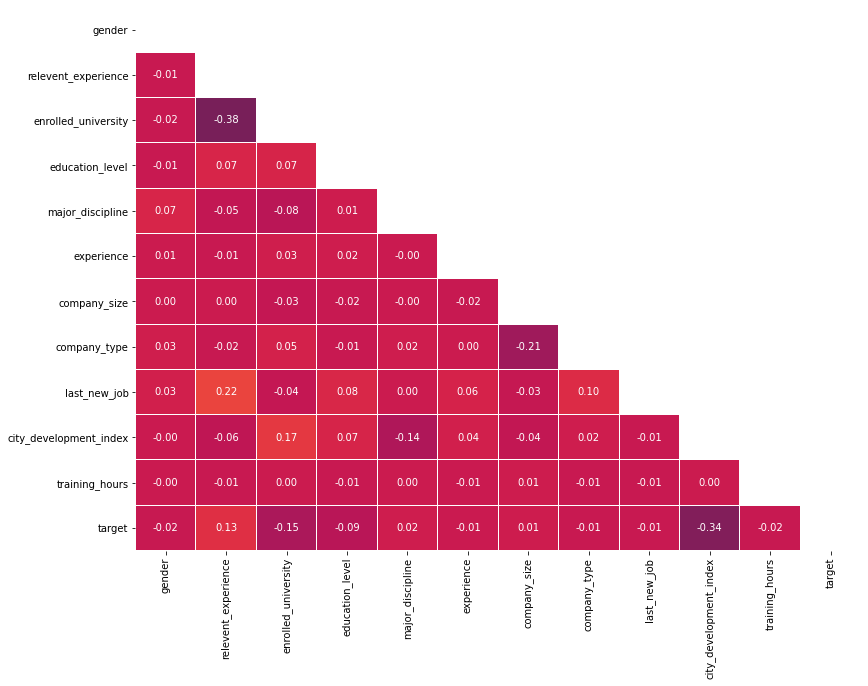

In [ ]:
import seaborn as sns
import numpy as np
matrix = np.triu(final_df.corr())
plt.figure(figsize=(13, 10))
sns.heatmap(final_df.corr(), annot = True, fmt=".2f", mask = matrix,
            vmin = -1, vmax = 1, linewidths = 0.1, linecolor = 'white', cbar = False)
plt.show()
#corrMatrix = data.corr()
#sns.heatmap(corrMatrix, annot=True)
#plt.show()

# Train-Test Split & Standard Scalar & Data Imbalancing -SMOTE

In [ ]:
y_true = final_df["target"]
final_df["target"].value_counts(normalize=True)

0.0    0.750652
1.0    0.249348
Name: target, dtype: float64

In [ ]:
from imblearn.over_sampling import SMOTE,ADASYN, SVMSMOTE
from imblearn.under_sampling import NearMiss
from sklearn.model_selection import train_test_split

X = final_df.drop('target',1)
y = final_df.target


# X_train0, X_test, y_train0, y_test = train_test_split(X,y , test_size = 0.3,random_state=101)

# sc = StandardScaler()
# X_train = sc.fit_transform(X_train0)
# X_test = sc.transform(X_test0)

svm_smote = SMOTE( random_state=101) #,sampling_strategy='minority', k_neighbors=5)
X_svm_smote, y_svm_smote = svm_smote.fit_resample(X,y)

X_train_svm, X_test_svm, y_train, y_test = train_test_split(X_svm_smote,y_svm_smote, test_size=0.30, random_state=101)

sc = StandardScaler()
X_train = sc.fit_transform(X_train_svm)
X_test = sc.transform(X_test_svm)


In [ ]:
print("Number of data points in train data :",X_train.shape)
print("Number of data points in validation data :",X_test.shape)

Number of data points in train data : (20133, 11)
Number of data points in validation data : (8629, 11)


In [ ]:
from collections import Counter

print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",round(int(train_distr[0])*100/train_len,2),"Class 1: ", round(int(train_distr[1])*100/train_len,2))

print("-"*10, "Distribution of output variable in validation data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",round(int(test_distr[0])*100/test_len,2), "Class 1: ",round(int(test_distr[1])*100/test_len,2))

---------- Distribution of output variable in train data ----------
Class 0:  49.84 Class 1:  50.16
---------- Distribution of output variable in validation data ----------
Class 0:  50.37 Class 1:  49.63


In [ ]:
print("X_train",X_train.shape)
print("X_test",X_test.shape)
print("y_train",y_train.shape)
print("y_test",y_test.shape)
# X_train = pd.DataFrame(X_train)
# X_train.columns = X_test.columns



X_train (20133, 11)
X_test (8629, 11)
y_train (20133,)
y_test (8629,)


In [ ]:
#!pip install plot_metric

In [ ]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divide each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    
    #divide each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    # Initialise the subplot function using number of rows and columns

    sns.set(font_scale=1)
    labels = [0,1]
    # representing A in heatmap format
    cmap1=sns.light_palette("orange")
    cmap2=sns.light_palette("#34c3eb")
    cmap3=sns.light_palette("purple")
    
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap1, fmt=".3f", xticklabels=labels, yticklabels=labels,annot_kws={"size":14})
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap2, fmt=".3f", xticklabels=labels, yticklabels=labels,annot_kws={"size":14})
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap3, fmt=".3f", xticklabels=labels, yticklabels=labels,annot_kws={"size":14})
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()


def plot_roc_auc(y_test,y_pred):
    from plot_metric.functions import BinaryClassification
    # Visualisation with plot_metric
    bc = BinaryClassification(y_test, y_pred, labels=["Class 1", "Class 0"])

    # Figures
    plt.figure(figsize=(8,7))
    bc.plot_roc_curve()
    
    plt.show()    

In [ ]:
import numpy as np
from sklearn.metrics import auc, accuracy_score, confusion_matrix, f1_score, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

# model accuracy
result = []

# KNN Classifier

Fitting 10 folds for each of 40 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  4.1min finished




RESULTS :
KNN Model Acc :  0.81
KNN Model F1-score :  0.81
Classification Report :               precision    recall  f1-score   support

         0.0       0.83      0.79      0.81      4346
         1.0       0.79      0.84      0.81      4283

    accuracy                           0.81      8629
   macro avg       0.81      0.81      0.81      8629
weighted avg       0.81      0.81      0.81      8629





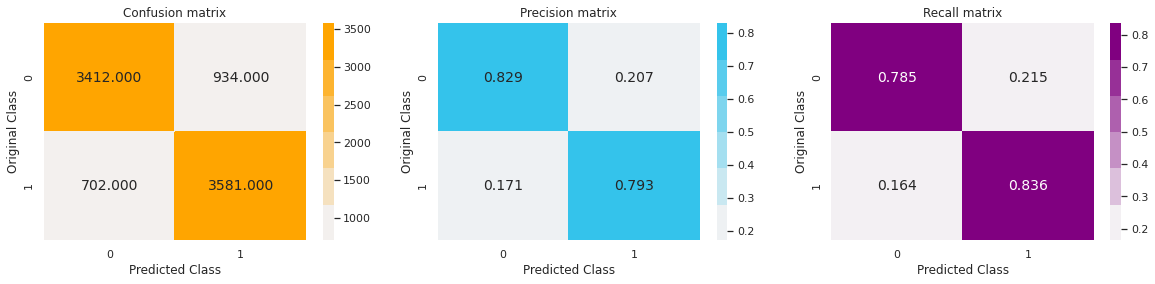

In [ ]:
knn_param_grid = {"n_neighbors": np.linspace(1,19,10, dtype = int).tolist(),
                 "weights": ["uniform","distance"],
                 "metric":["euclidean","manhattan"]}

knn = KNeighborsClassifier()
clf = GridSearchCV(knn, param_grid=knn_param_grid, cv = StratifiedKFold(n_splits = 10), 
                   scoring = "accuracy", n_jobs = -1,verbose = 1)
clf.fit(X_train,y_train)
y_pred_knn = clf.predict(X_test)
cm_random_knn = confusion_matrix(y_test,y_pred_knn)
acc_random_knn = accuracy_score(y_test, y_pred_knn)
fscore = f1_score(y_test,y_pred_knn)
result.append(acc_random_knn)

print('\n')
print("RESULTS :")
print("KNN Model Acc : ",round(acc_random_knn,2))
print("KNN Model F1-score : ",round(fscore,2))
print("Classification Report :",classification_report(y_test,y_pred_knn))
print('\n')
plot_confusion_matrix(y_test, y_pred_knn)

# XGBoost Classifier

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    5.9s finished


RESULTS : 
XGBoost Model Accuracy :  0.9
XGBoost Model F1-score :  0.9
Classification Report :
               precision    recall  f1-score   support

         0.0       0.90      0.91      0.91      4346
         1.0       0.91      0.90      0.90      4283

    accuracy                           0.90      8629
   macro avg       0.90      0.90      0.90      8629
weighted avg       0.90      0.90      0.90      8629





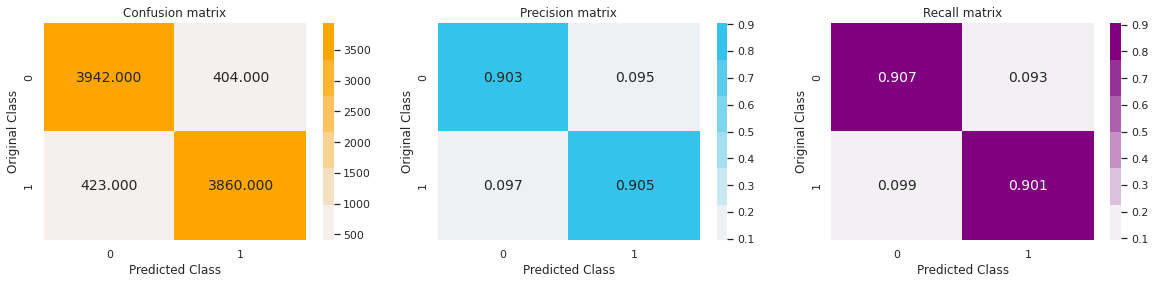

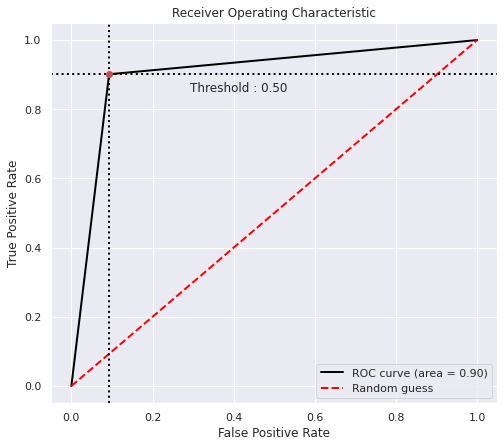

In [ ]:
import xgboost as xgb
from sklearn.calibration import CalibratedClassifierCV

parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['binary:logistic'],
              'learning_rate': [0.1], #so called `eta` value
              'max_depth': [5],
              'min_child_weight': [7],
              'silent': [1],
              'subsample': [0.8],
              'colsample_bytree': [0.7],
              'n_estimators': [100], #number of trees, change it to 1000 for better results
              'seed': [1337]}

XGB = xgb.XGBClassifier()
XGB = GridSearchCV(XGB, parameters, cv = StratifiedKFold(5, shuffle=True), 
                   scoring='roc_auc',
                   verbose=1, refit=True)
# XGB = CalibratedClassifierCV(XGB, method="sigmoid")
XGB.fit(X_train, y_train)
y_pred_xgb = XGB.predict(X_test)
cm_xgb = confusion_matrix(y_pred_xgb,y_test)
fscore = f1_score(y_test,y_pred_xgb)
acc_xgb = accuracy_score(y_test, y_pred_xgb)
result.append(acc_xgb)


print("RESULTS : ")
print("XGBoost Model Accuracy : ",round(acc_xgb,2))
print("XGBoost Model F1-score : ",round(fscore,2))
print("Classification Report :\n",classification_report(y_test,y_pred_xgb))
print('\n')
plot_confusion_matrix(y_test, y_pred_xgb)
print('\n')
plot_roc_auc(y_test,y_pred_xgb)

# Random Forest Classifier

RESULTS :
Random Forest Model Accuracy :  0.75
Random Forest Model F1-score :  0.75
Classification Report :               precision    recall  f1-score   support

         0.0       0.75      0.77      0.76      4346
         1.0       0.76      0.74      0.75      4283

    accuracy                           0.75      8629
   macro avg       0.75      0.75      0.75      8629
weighted avg       0.75      0.75      0.75      8629





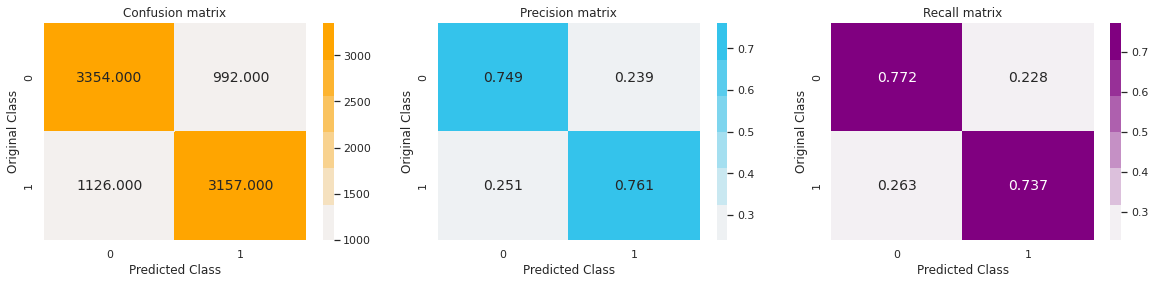

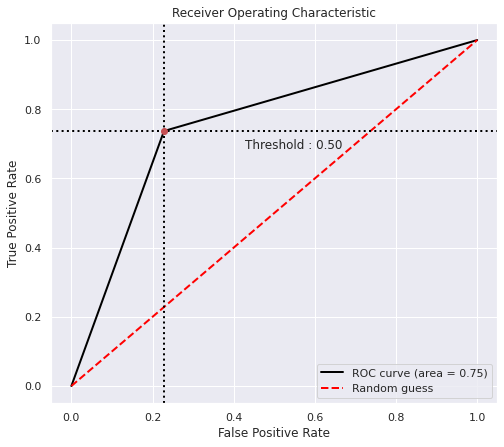

In [ ]:
from sklearn.ensemble import RandomForestClassifier
random_forest_model = RandomForestClassifier(max_depth=2, random_state= 59)
random_forest_model.fit(X_train, y_train)
y_pred_random_forest = random_forest_model.predict(X_test)
cm_random_forest = confusion_matrix(y_pred_random_forest,y_test)
fscore = f1_score(y_test,y_pred_random_forest)
acc_random_forest = accuracy_score(y_test, y_pred_random_forest)
result.append(acc_random_forest)

print("RESULTS :")
print("Random Forest Model Accuracy : ",round(acc_random_forest,2))
print("Random Forest Model F1-score : ",round(fscore,2))
print("Classification Report :",classification_report(y_test,y_pred_random_forest))
print('\n')
plot_confusion_matrix(y_test, y_pred_random_forest)
print('\n')
plot_roc_auc(y_test,y_pred_random_forest)

# Light Gradient Boosting Model

RESULTS :
LGB Model Accuracy :  0.91
LGB Model F1-score :  0.91
Classification Report :               precision    recall  f1-score   support

         0.0       0.91      0.91      0.91      4346
         1.0       0.91      0.91      0.91      4283

    accuracy                           0.91      8629
   macro avg       0.91      0.91      0.91      8629
weighted avg       0.91      0.91      0.91      8629





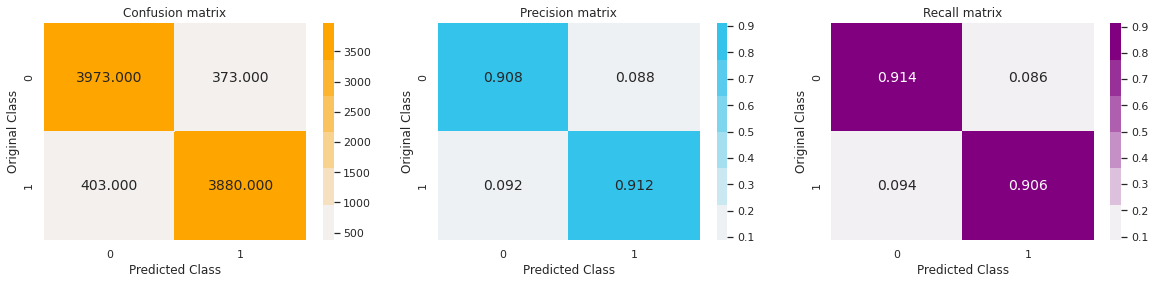

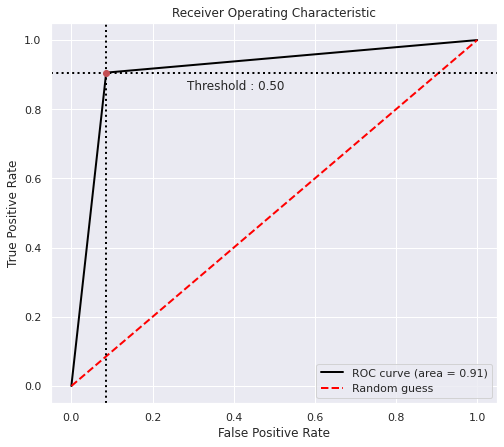

In [ ]:
from lightgbm import LGBMClassifier
import lightgbm as lgb
clf_lgb = lgb.LGBMClassifier()
clf_lgb.fit(X_train, y_train)
y_pred=clf_lgb.predict(X_test)

fscore = f1_score(y_test,y_pred)
acc_lgb = accuracy_score(y_pred, y_test)
result.append(acc_lgb)

print("RESULTS :")
print("LGB Model Accuracy : ",round(acc_lgb,2))
print("LGB Model F1-score : ",round(fscore,2))
print("Classification Report :",classification_report(y_test,y_pred))
print('\n')
plot_confusion_matrix(y_test, y_pred)
print('\n')
plot_roc_auc(y_test,y_pred)


# Artificial Neural Network

RESULTS :
ANN Accuracy :  0.91
ANN F1-score :  0.78
Classification Report :               precision    recall  f1-score   support

         0.0       0.80      0.74      0.76      4346
         1.0       0.75      0.81      0.78      4283

    accuracy                           0.77      8629
   macro avg       0.77      0.77      0.77      8629
weighted avg       0.77      0.77      0.77      8629





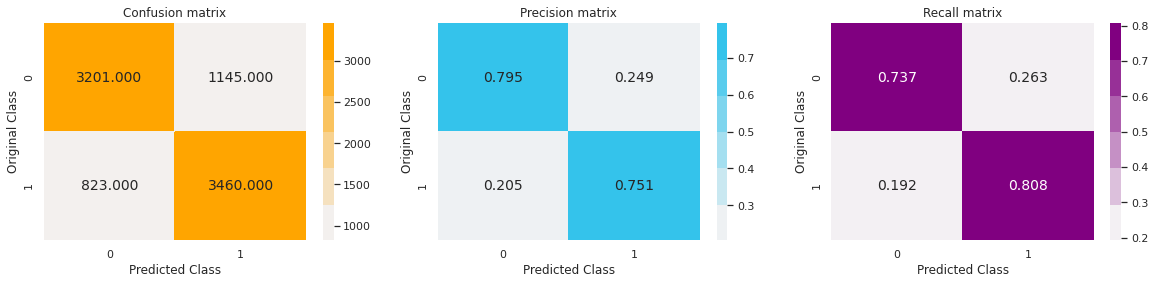

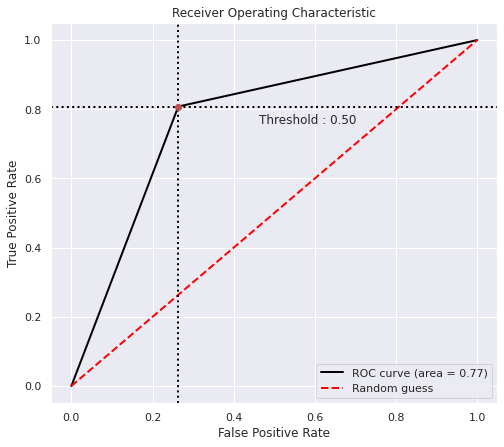

In [ ]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(8,8,8), activation='relu', solver='adam', max_iter=500)
mlp.fit(X_train,y_train)

predict_train = mlp.predict(X_train)
y_pred = mlp.predict(X_test)

fscore = f1_score(y_test,y_pred)
acc_mlp = accuracy_score(y_pred, y_test)
result.append(acc_mlp)

print("RESULTS :")
print("ANN Accuracy : ",round(acc_lgb,2))
print("ANN F1-score : ",round(fscore,2))
print("Classification Report :",classification_report(y_test,y_pred))
print('\n')
plot_confusion_matrix(y_test, y_pred)
print('\n')
plot_roc_auc(y_test,y_pred)

# Final Results

In [ ]:
results = pd.DataFrame({"Model Result":result, 
                        "Models":["KNN",
                                  "XGBoost",
                                  "RandomForest",
                                  "LGBM",
                                  "ANN"]})

results

,Model Result,Models
0,0.810407,KNN
1,0.904160,XGBoost
2,0.754549,RandomForest
3,0.910071,LGBM
4,0.771932,ANN


# Feature Importance

In [ ]:
#!pip install eli5

In [ ]:
from sklearn.inspection import permutation_importance
import eli5
from eli5.sklearn import PermutationImportance

pimp = PermutationImportance(estimator = XGB, 
                                         scoring = 'f1', random_state=101, n_iter = 5)
pimp.fit(X_test, y_test);

print(eli5.show_weights(pimp, feature_names = X.columns.to_list()))

feature_imp = pd.DataFrame(np.hstack((np.array([X.columns[0:]]).T, 
                              pimp.feature_importances_.T.reshape(-1,1))), 
                              columns=['feature', 'importance'])

feature_imp['importance'] = pd.to_numeric(feature_imp['importance'])
feature_imp.sort_values(by='importance', ascending=False)

<IPython.core.display.HTML object>


,feature,importance
0,gender,0.130687
9,city_development_index,0.062866
7,company_type,0.042161
1,relevent_experience,0.023135
4,major_discipline,0.021555
6,company_size,0.018643
3,education_level,0.018168
8,last_new_job,0.013411
5,experience,0.003986
2,enrolled_university,0.001229


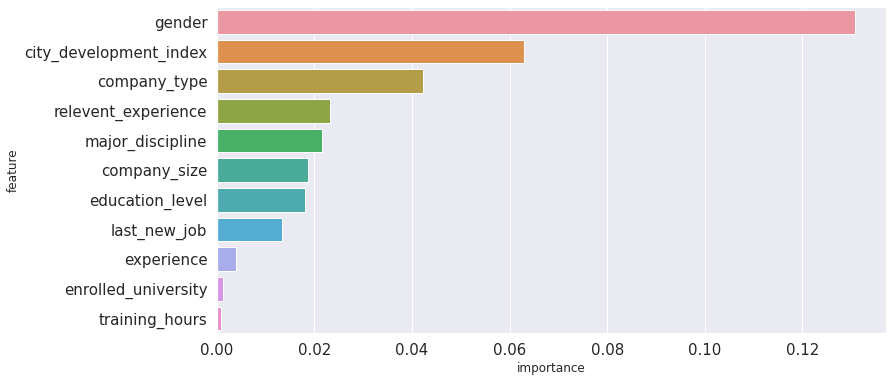

In [ ]:
plt.figure(figsize = (12,6))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# We sort by importance and get the features
sns.barplot(x = 'importance', y = 'feature', data = feature_imp, 
            order = feature_imp.sort_values('importance', ascending=False).feature) ;

* Gender is most important factor to understand whether he or she will change the job or not, followed by City Development Index and Company Type.

# End!